# Exploring the Adver-City Dataset 

This notebook explores the Adver-City Dataset, a synthetic dataset for cooperative perception in adverse weather conditions. The dataset is located here: https://labs.cs.queensu.ca/quarrg/datasets/adver-city/.


 The datafiles are formatted as follows:
`[prefix]_[weather]_[density].7z`, where:
- `prefix` denotes one of various CARLA maps and/or scenario families
- `weather` denotes the weather condition code
- `density` denote the density of the scene (`['dense', 'sparse']`)

Notes: 
- ensure to source virtual environment located at `./venv/bin/python` before running: `source venv/bin/activate`
- requirements have been exported to `pip freeze > requirements.txt`
- data ingests and extracts from data format `.7z`, which requires a system executable outside venv (hence, our use of `subprocess`)
- to unzip the `.7z` files using this subprocess, install p7zip as follows: `brew install p7zip`

This data exploration notebook allows us to familiarize ourselves with the dataset. Along the way, we build some utility functions for data ingestion and manipulation that will be useful later on. This is why, as a shortcut, we rely on a custom modules in the higher project directory.

## Table of Contents

- 

##  Access the Data

Import necessary libraries and set project root

In [1]:
# imports (standard)
from pathlib import Path
import os
import yaml

# move to project project director 
cwd = Path.cwd()
if cwd.name == "data_exploration":
    os.chdir(cwd.parent)
    print("changed to root directory:", Path.cwd())
else:
    print("already in project root:", Path.cwd())

# imports (from project directory)
from data_ingestion import explore, build


changed to root directory: /Users/tjards/Library/CloudStorage/Dropbox/adjunctQueens/code/pytorch_project_advercity


Create dictionaries of valid values for easier access and error checking.

In [2]:
# various CARLA maps and scenario families
VALID_PREFIX = {
    "rcnj", 
    "ri", 
    "rsnj", 
    "ui", 
    "unj"
}

# weather types
VALID_WEATHER = {
    "cd": "clear day",
    "cn": "clear night",
    "fd": "fog day",
    "fn": "fog night",
    "hrd": "heavy rain day",
    "hrn": "heavy rain night",
    "srd": "soft rain day",
    "srn": "soft rain night",
    "gd": "glare day",
    "fhrd": "fog + heavy rain day",
    "fhrn": "fog + heavy rain night",
}

# density of the scene
VALID_DENSITY = {
    "s": "sparse",
    "d": "dense",
}


Configure the remote server URL and specify which file(s) to download for exploration.

In [3]:

# path to where files are stored
DATA_DIR = "./data_exploration/data"
BASE_URL = "https://www.frdr-dfdr.ca/repo/files/1/published/publication_1079/submitted_data"

# specify which file (automate this later)
PREFIX = "rcnj"
WEATHER = "cn"
DENSITY = "s"

FILENAME = explore.build_filename(
    prefix=PREFIX,
    weather=WEATHER,
    density=DENSITY,
    VALID_PREFIX=VALID_PREFIX,
    VALID_WEATHER=VALID_WEATHER,
    VALID_DENSITY=VALID_DENSITY,
)

print('filename: ', FILENAME)

filename:  rcnj_cn_s.7z


Download the file (if not aleady done).

In [4]:
print('requesting', FILENAME, ' from remote server...') 
DOWNLOAD_URL = f"{BASE_URL}/{FILENAME}"
print('from url:', DOWNLOAD_URL)
FILE_PATH = explore.download_file(DATA_DIR, DOWNLOAD_URL, FILENAME)
print('file located at: ', FILE_PATH)

requesting rcnj_cn_s.7z  from remote server...
from url: https://www.frdr-dfdr.ca/repo/files/1/published/publication_1079/submitted_data/rcnj_cn_s.7z
A file already exists, skipping download:
  ./data_exploration/data/rcnj_cn_s.7z
file located at:  ./data_exploration/data/rcnj_cn_s.7z


Extract the contents of the downloaded file.

In [5]:
DIR_EXTRACTED = explore.extract_file(
    DIR_IN=DATA_DIR,
    FILENAME_IN=FILENAME,
    DIR_OUT=DATA_DIR+"/extracted"
)

Already extracted, skipping:
  ./data_exploration/data/extracted/rcnj_cn_s


## Discover Structure

Display the folder structure as a tree

In [6]:
print('directory tree for ', DIR_EXTRACTED, ':')
explore.print_folder_tree(DIR_EXTRACTED, max_depth=1)
AGENT_IDS = explore.get_agent_ids(DIR_EXTRACTED, include_negative=True)
print('list of AGENT IDs in this folder: \n', list(AGENT_IDS))

directory tree for  ./data_exploration/data/extracted/rcnj_cn_s :
rcnj_cn_s/
├── -1/
├── -2/
├── 1011/
├── 1025/
├── 1039/
├── data_protocol.yaml
└── summary.yaml
list of AGENT IDs in this folder: 
 ['-2', '-1', '1011', '1025', '1039']


We can see two .yaml files with configuration and metadata and agent/vehicle IDs. Let's look at the summary.yaml file to get an overview of the dataset.

In [7]:
DATA_SUMMARY_PATH = DIR_EXTRACTED+"/summary.yaml"
print("summary for data at:", DATA_SUMMARY_PATH)
with open(DATA_SUMMARY_PATH, "r") as f:
    summary_data = yaml.safe_load(f)
print(yaml.safe_dump(summary_data, sort_keys=False))

summary for data at: ./data_exploration/data/extracted/rcnj_cn_s/summary.yaml
simulation: rcnj_cn_s
scenario: rural_curved_non_junction
weather: clear
time_of_day: night
density: sparse
num_frames: 190
num_vehicles: 21
num_walkers: 0
frames:
  60:
    cav_speeds:
      ego: 37.48457299049714
      cav1: 27.921569795082934
      cav2: 38.47125400005063
    num_annotations: 18
    1075:
      class: car
      speed: 26.47415158892431
      distance_to_ego: 49.57381057739258
      angle_to_ego: -121.1683120727539
    1076:
      class: van
      speed: 18.96085240963301
    1082:
      class: van
      speed: 12.681598250566514
    1084:
      class: bicycle
      speed: 12.92454995295947
    1085:
      class: car
      speed: 20.442992010551688
    1086:
      class: van
      speed: 25.435691705515506
    1088:
      class: car
      speed: 24.747269309299263
    1091:
      class: truck
      speed: 19.747792429655863
      distance_to_ego: 59.07536697387695
      angle_to_ego: 59.450

Here we can see the scenario is `rural_curved_non_junction` with `clear` weather during the `night`. The dataset contains total 21 agents/vehicles. The folders are for the data **data-producing agents/vehicles** (i.e., those with the cameras). Other agents/vehicles are annotated in various `frames'. 

# Inspect Content 

Let's pick one specific agent and look a bit deeper.

In [8]:
AGENT_ID = AGENT_IDS[2] #optionally, specify directly as "1011", ... etc
print('directory tree for ', DIR_EXTRACTED+"/"+str(AGENT_ID), ':')
explore.print_folder_tree(DIR_EXTRACTED+"/"+str(AGENT_ID), max_depth=2)

directory tree for  ./data_exploration/data/extracted/rcnj_cn_s/1011 :
1011/
├── 000060.yaml
├── 000060_camera0.png
├── 000060_camera1.png
├── 000060_camera2.png
├── 000060_camera3.png
├── 000060_gnss_imu.yaml
├── 000060_lidar.ply
├── 000060_semantic1.png
├── 000060_semantic2.png
├── 000060_semantic3.png
├── 000061.yaml
├── 000061_camera0.png
├── 000061_camera1.png
├── 000061_camera2.png
├── 000061_camera3.png
├── 000061_gnss_imu.yaml
├── 000061_lidar.ply
├── 000061_semantic0.png
├── 000061_semantic1.png
├── 000061_semantic2.png
├── 000061_semantic3.png
├── 000062.yaml
├── 000062_camera0.png
├── 000062_camera1.png
├── 000062_camera2.png
├── 000062_camera3.png
├── 000062_gnss_imu.yaml
├── 000062_lidar.ply
├── 000062_semantic0.png
├── 000062_semantic1.png
├── 000062_semantic2.png
├── 000062_semantic3.png
├── 000063.yaml
├── 000063_camera0.png
├── 000063_camera1.png
├── 000063_camera2.png
├── 000063_camera3.png
├── 000063_gnss_imu.yaml
├── 000063_lidar.ply
├── 000063_semantic0.png
├── 000

Here we see the images (in .png format) produced by the selected AGENT_ID's various cameras, indexed by the `frame` ID. There are also .yaml files for each frame. Let's quickly inspect one of these .yaml files to see what metadata is provided.

In [9]:
FRAME_ID = "000060"
FRAME_PATH = DIR_EXTRACTED+"/"+str(AGENT_ID)+"/"+str(FRAME_ID)+".yaml"
print(str(FRAME_PATH))
print("metadata for frame at:", FRAME_PATH)
with open(FRAME_PATH, "r") as f:
    frame_metadata = yaml.safe_load(f)
print(yaml.safe_dump(frame_metadata, sort_keys=False))

./data_exploration/data/extracted/rcnj_cn_s/1011/000060.yaml
metadata for frame at: ./data_exploration/data/extracted/rcnj_cn_s/1011/000060.yaml
RSU: false
camera0:
  cords:
  - 68.41932678222656
  - -42.19554901123047
  - 3.808724880218506
  - 0.04656583443284035
  - -138.46652221679688
  - 4.805174350738525
  extrinsic:
  - - 1.0
    - -1.889048141136061e-16
    - -3.3023009692718086e-18
    - -0.9499967603398396
  - - -3.127514015704538e-17
    - 0.9999999999999998
    - 6.327602932046738e-18
    - 6.475694505070351e-07
  - - 5.853078658478853e-18
    - -1.4994452834307173e-17
    - 0.9999999999999999
    - 0.4499992445328216
  - - 0.0
    - 0.0
    - 0.0
    - 1.0
  intrinsic:
  - - 805.5356459301888
    - 0.0
    - 960.0
  - - 0.0
    - 805.5356459301888
    - 540.0
  - - 0.0
    - 0.0
    - 1.0
camera1:
  cords:
  - 69.39923858642578
  - -42.19597625732422
  - 3.8168017864227295
  - 4.724479675292969
  - -38.504730224609375
  - -0.8791614174842834
  extrinsic:
  - - -0.1736484133

Which we see contains the positions of the agents/vehicles in the frame, relative to the position of the data-producing agent/vehicle's camera. Let's look at a few of the camera images.

returning all images for cameras at:  ./data_exploration/data/extracted/rcnj_cn_s/1011
found  9  images
Found 1 unique image size(s) in 9 images:
  1920 × 1080


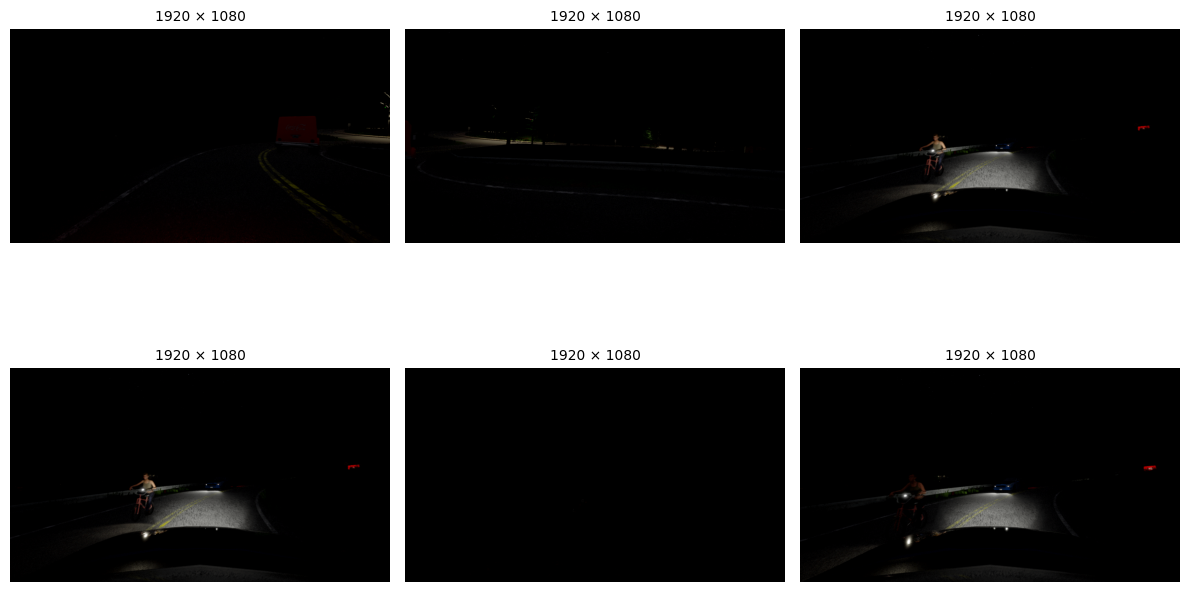

In [10]:
print('returning all images for cameras at: ', DIR_EXTRACTED+"/"+str(AGENT_ID))
imgs = explore.find_imgs(DIR_EXTRACTED+"/"+str(AGENT_ID), camera=None, ext=".png", limit=9)
print('found ', len(imgs), ' images')

sizes = explore.list_image_sizes(imgs)
explore.show_images_grid(imgs, rows=2, cols=3, randomize = True)


## Build an Index

Parse through the various folders to build an index suitable for ML applications. 

In [11]:
df = build.build_index(DIR_EXTRACTED, camera = None, ext = '.png', limit = 1000) # any 'camera', limit is per agent (should be high)

Inspect the size of the dataframe

In [12]:
df.shape

(2280, 8)

Show me some basic info

In [13]:
df.info

<bound method DataFrame.info of       data_name prefix weather density  agent_id  frame_id   camera  \
0     rcnj_cn_s   rcnj      cn       s      1011        60  camera0   
1     rcnj_cn_s   rcnj      cn       s      1011        60  camera1   
2     rcnj_cn_s   rcnj      cn       s      1011        60  camera2   
3     rcnj_cn_s   rcnj      cn       s      1011        60  camera3   
4     rcnj_cn_s   rcnj      cn       s      1011        61  camera0   
...         ...    ...     ...     ...       ...       ...      ...   
2275  rcnj_cn_s   rcnj      cn       s      1039       248  camera3   
2276  rcnj_cn_s   rcnj      cn       s      1039       249  camera0   
2277  rcnj_cn_s   rcnj      cn       s      1039       249  camera1   
2278  rcnj_cn_s   rcnj      cn       s      1039       249  camera2   
2279  rcnj_cn_s   rcnj      cn       s      1039       249  camera3   

                                             image_path  
0     data_exploration/data/extracted/rcnj_cn_s/1011...  

Look at the first few rows

In [14]:
df.head()

,data_name,prefix,weather,density,agent_id,frame_id,camera,image_path
0,rcnj_cn_s,rcnj,cn,s,1011,60,camera0,data_exploration/data/extracted/rcnj_cn_s/1011...
1,rcnj_cn_s,rcnj,cn,s,1011,60,camera1,data_exploration/data/extracted/rcnj_cn_s/1011...
2,rcnj_cn_s,rcnj,cn,s,1011,60,camera2,data_exploration/data/extracted/rcnj_cn_s/1011...
3,rcnj_cn_s,rcnj,cn,s,1011,60,camera3,data_exploration/data/extracted/rcnj_cn_s/1011...
4,rcnj_cn_s,rcnj,cn,s,1011,61,camera0,data_exploration/data/extracted/rcnj_cn_s/1011...


Save the index for later 

In [ ]:
FILENAME_INDEX = 'data_index'
DIR_INDEX = DATA_DIR+"/indexed"

index_path = build.save_index(df, DIR_INDEX, FILENAME_INDEX, '.csv')
print("Saved to:", index_path)


Saved to: data_exploration/data/extracted/rcnj_cn_s/data_index.csv


## Extend to multiple datasets